## 1. SETUP

### 1.1 Importar Libs

In [1]:
# Importação das bibliotecas necessárias
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
from joblib import load, dump
from scipy.stats import randint, loguniform, uniform
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Importar funções dos módulos customizados
from ml_utils import gmean_score, evaluate_model, load_and_prepare_datasets
from search_utils import (multiple_randomized_search, plot_search_history, save_search_results, 
                          save_final_results, DEFAULT_CV_STRATEGY, plot_search_history_from_loaded,
                          load_search_results, get_best_params_from_saved)

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.3
NumPy: 2.3.3
Scikit-learn: 1.7.2


### 1.2 Configuração do Modelo

In [2]:
# Configuração do modelo e hiperparâmetros
MODEL_NAME = "SVM"
MODEL_CLASS = SVC
RANDOM_STATE_MODEL = 10
RANDOM_STATE_SAMPLE = 10

# Configuração da busca de hiperparâmetros
N_SEARCHES = 20
N_ITER_PER_SEARCH = 5
SAMPLE_SIZE = 0.05 # % of training data 

# Pastas para salvamento
SEARCHES_FOLDER = 'searches'
RESULTS_FOLDER = 'results'
MODELS_FOLDER = 'models'

print(f"Modelo configurado: {MODEL_NAME}")
print(f"Classe do modelo: {MODEL_CLASS}")
print(f"Buscas: {N_SEARCHES} x {N_ITER_PER_SEARCH} iterações")

Modelo configurado: SVM
Classe do modelo: <class 'sklearn.svm._classes.SVC'>
Buscas: 20 x 5 iterações


## 2. CARREGAMENTO E PREPARAÇÃO DOS DADOS

In [3]:
# Carregamento e preparação inicial dos dados
print("=== CARREGAMENTO DOS DATASETS ===")

# Carregar e preparar datasets usando função do módulo
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, train_data, test_data, scaler = load_and_prepare_datasets()

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")
print(f"Features: {X_train_scaled.shape[1]}")

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

# Mostrar sample dos dados
print("\nPrimeiras linhas do dataset de treino:")
display(train_data.head())

=== CARREGAMENTO DOS DATASETS ===
Dataset de treino: (72795, 17)
Dataset de teste: (8180, 17)
Features: 16

Distribuição das classes:
Treino: {0.0: 54175, 1.0: 18620}
Teste: {0.0: 5894, 1.0: 2286}

Primeiras linhas do dataset de treino:


,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Gender,HospAdmTime,ICULOS,SepsisLabel
0,-0.828259,-0.396817,0.890288,-1.189896,0.268219,0.158164,0.391841,0.579093,1.632205,0.855053,0.706987,1.433318,0.068024,-1.140335,0.356849,-0.838308,0.0
1,-0.478847,-0.673800,-1.872530,0.324391,1.492201,-0.386455,-0.161934,-0.113524,-0.304515,1.156973,0.656064,-0.813046,1.079563,-1.140335,0.304841,-0.489607,0.0
2,-0.804965,0.544922,-0.644611,0.450581,1.249928,1.065862,-0.662070,-0.345514,0.976526,1.689773,1.623609,-1.137985,-0.149065,0.876935,0.357194,-0.815061,0.0
3,-0.525435,-0.396817,0.583308,-1.745135,-0.084618,0.702783,0.746309,0.543080,-1.476333,0.002573,-0.311482,-0.705572,-0.116992,0.876935,-0.584873,-0.536101,0.0
4,-0.665200,-1.061575,-0.644611,0.488439,0.387085,-0.567994,0.272113,-2.489717,-0.248842,0.748493,0.808834,-0.088417,0.940833,-1.140335,0.357194,-0.675581,0.0


## 3. SAMPLING PARA BUSCA DE HIPERPARÂMETROS

In [4]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Amostra estratificada do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train,
    test_size=SAMPLE_SIZE,
    stratify=y_train,
    random_state=RANDOM_STATE_SAMPLE
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 72,795 amostras
Amostra para busca de hiperparâmetros: 3,640 amostras
Redução: 95.0%

Distribuição das classes na amostra:
Amostra: {0.0: 2709, 1.0: 931}
Original: {0.0: 54175, 1.0: 18620}


## 4. DEFINIR ESTRATÉGIA DE VALIDAÇÃO CRUZADA

In [5]:
# Usar estratégia de CV padrão dos módulos
cv_strategy = DEFAULT_CV_STRATEGY
print(f"Estratégia de CV: {cv_strategy}")

Estratégia de CV: StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


## 5. SVM - BUSCA DE HIPERPARÂMETROS



### 5.1 Definir Espaço de Hiperparâmetros

In [ ]:
# ======================================================================
# DEFINIÇÃO DO ESPAÇO DE HIPERPARÂMETROS
# ======================================================================

# Definir hiperparâmetros específicos para Decision Tree
param_distributions = {
    'C': uniform(5, 50),                      # Distribuição uniforme para C
    'kernel': ['rbf', 'linear', 'sigmoid'],   # Tipos de kernel
    'gamma': loguniform(0.01, 10)             # Parâmetro gamma
}


### 5.2 Executar Busca de Hiperparâmetros

In [ ]:
# ======================================================================
# BUSCA DE HIPERPARAMETROS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME} ===")
print(f"Iniciando busca de hiperparâmetros para {MODEL_NAME}...")
print(f"Executando {N_SEARCHES} buscas com {N_ITER_PER_SEARCH} iterações cada...")
print(f"Usando amostra de {X_sample.shape[0]:,} exemplos\n")

# Múltiplas execuções do RandomizedSearchCV
search, all_searches, best_params = multiple_randomized_search(
    estimator=MODEL_CLASS(random_state=RANDOM_STATE_MODEL, probability=True),
    param_distributions=param_distributions,
    X=X_sample,
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=N_SEARCHES,
    n_iter_per_search=N_ITER_PER_SEARCH,
    scoring='f1',
    random_state=None,
    n_jobs=-1
)

# Exibir os melhores resultados
print(f"\n--- RESULTADOS {MODEL_NAME} ---")
print("Melhores hiperparâmetros encontrados:")
for param, value in search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMelhor F1-Score (CV): {search.best_score_:.4f}")
print(f"Desvio padrão: {search.cv_results_['std_test_score'][search.best_index_]:.4f}")

### 5.3 Visualizar Histórico da Busca

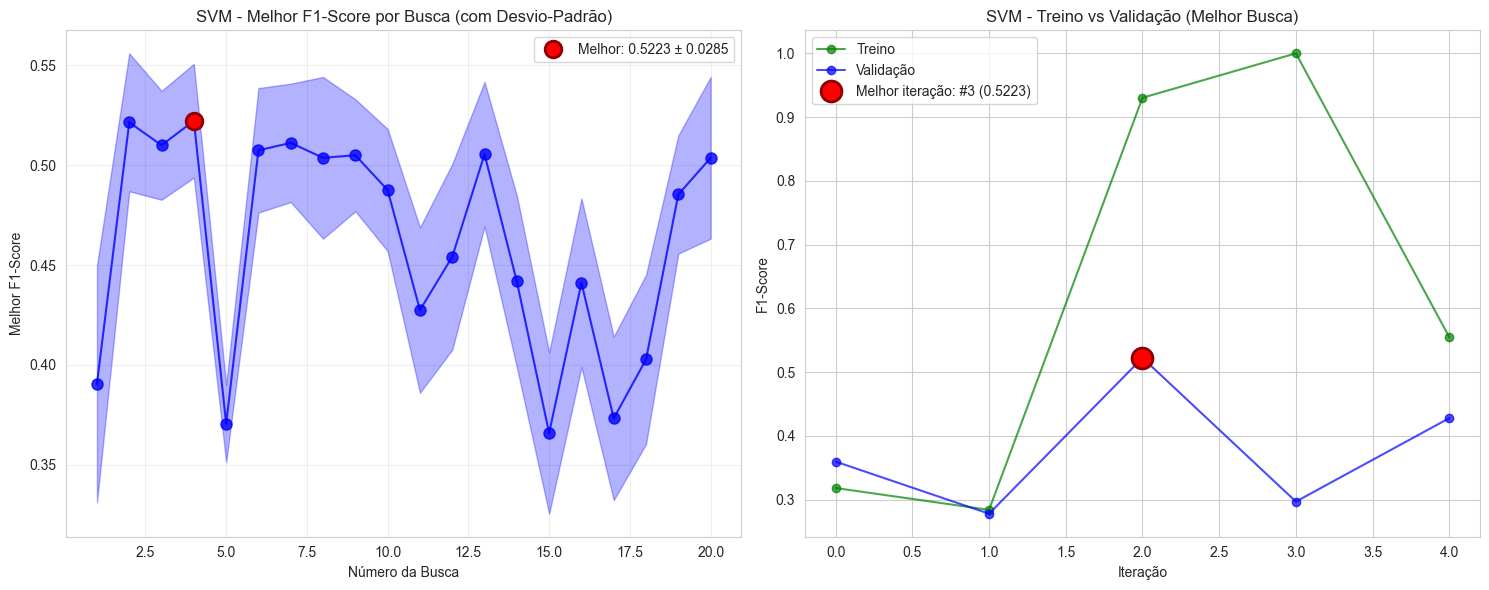

In [8]:
# Registro de Desempenho - plotar evolução da busca
plot_search_history(all_searches, search, MODEL_NAME)

In [9]:
# ======================================================================
# ANÁLISE DAS MELHORES CONFIGURAÇÕES ENCONTRADAS
# ======================================================================

print(f"=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - {MODEL_NAME} ===")

# Extrair os melhores resultados de cada busca
best_configs = []

for i, search_result in enumerate(all_searches):
    config = {
        'Busca': i + 1,
        'F1_Score': search_result['best_score'],
        **search_result['best_params']
    }
    best_configs.append(config)

# Criar DataFrame e exibir top configs
results_df = pd.DataFrame(best_configs)
results_df = results_df.sort_values('F1_Score', ascending=False).round(4)

print(f"\nTop configurações (de {len(results_df)} buscas):")
print(results_df.to_string(index=False))

print(f"\nEstatísticas dos F1-Scores encontrados:")
print(f"  Média: {results_df['F1_Score'].mean():.4f}")
print(f"  Mediana: {results_df['F1_Score'].median():.4f}")
print(f"  Desvio padrão: {results_df['F1_Score'].std():.4f}")
print(f"  Min: {results_df['F1_Score'].min():.4f}")
print(f"  Max: {results_df['F1_Score'].max():.4f}")

=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - SVM ===

Top configurações (de 20 buscas):
 Busca  F1_Score       C  gamma  kernel
     4    0.5223 45.8443 0.0586     rbf
     2    0.5215 11.8645 0.1149     rbf
     7    0.5112 20.9266 0.0584     rbf
     3    0.5100 38.6618 0.0845     rbf
     6    0.5074 34.7073 0.0358     rbf
    13    0.5055 45.2840 0.1149     rbf
     9    0.5050 50.1583 0.0315     rbf
    20    0.5037 42.0181 0.1149     rbf
     8    0.5037 42.0123 0.1149     rbf
    10    0.4876 34.6507 0.0254     rbf
    19    0.4853 39.9147 0.0231     rbf
    12    0.4541 26.2204 0.2729     rbf
    14    0.4418 19.4336 0.0195     rbf
    16    0.4411 35.9134 0.0147     rbf
    11    0.4275  5.3461 0.0254     rbf
    18    0.4027 12.9982 0.1667 sigmoid
     1    0.3905 11.9467 0.0845 sigmoid
    17    0.3732 52.3117 0.4040     rbf
     5    0.3706 20.6608 0.7040 sigmoid
    15    0.3659 50.3462 0.0584 sigmoid

Estatísticas dos F1-Scores encontrados:
  Média: 0.4615
  Mediana

## 6. SALVAR RESULTADOS DE BUSCA

In [ ]:

search_df = save_search_results(
    model_name=MODEL_NAME,
    model_search=search,
    model_all_searches=all_searches,
    n_searches=N_SEARCHES,
    n_iter_per_search=N_ITER_PER_SEARCH,
    scoring='f1',
    cv_folds=cv_strategy.get_n_splits(),
    top_params_columns=param_distributions.keys(),
    searches_folder=SEARCHES_FOLDER
)

=== SALVANDO RESULTADOS DA BUSCA - SVM ===
  ✅ Todos os Resultados salvos: searches\svm_all_searches.csv
  Total de configurações testadas: 100
  ✅ Resumo salvo: searches\svm_search_summary.json

--- ESTATÍSTICAS DA BUSCA SVM ---
Melhor F1-Score: 0.5223
Desvio padrão do melhor: 0.0285
F1-Score médio geral: 0.3226
F1-Score mínimo: 0.0358
F1-Score máximo: 0.5223


### 6.2 Carregar Resultado de Busca (Opcional)

In [6]:
loaded_results = load_search_results(MODEL_NAME)

=== CARREGANDO RESULTADOS DE BUSCA - SVM ===
✅ Resultados detalhados carregados: 100 configurações
✅ Resumo carregado: F1-Score = 0.5223
⚠️  Arquivo não encontrado: searches\svm_full_search.pkl


In [ ]:
# Plotar a história da busca a partir dos resultados carregados
plot_search_history_from_loaded(loaded_results, MODEL_NAME)

### 6.3 Definir Melhores Params e CV score

In [8]:
# Definir Melhores Parâmetros para Uso Posterior
if 'loaded_results' in locals():
    best_params = get_best_params_from_saved(MODEL_NAME)
    if best_params:
        print(f"✅ Parâmetros carregados: {best_params}")
    best_score = loaded_results['summary']['best_overall_score']
    print(f"✅ Melhor F1-Score carregado: {best_score:.4f}")
else:
    best_params = search.best_params_
    best_score = search.best_score_
    print(f"✅ Usando parâmetros da busca atual: {best_params}")
    print(f"✅ Melhor F1-Score da busca atual: {best_score:.4f}")

✅ Parâmetros carregados: {'C': 45.844310993266205, 'gamma': 0.058608696262893716, 'kernel': 'rbf'}
✅ Melhor F1-Score carregado: 0.5223


## 7. TREINAR MODELO FINAL E SALVAR

In [12]:
# Treinamento Final com melhores hiperparâmetros


X_training, y_training = X_train_scaled, y_train
_, X_training, _, y_training = train_test_split(
    X_train_scaled, y_train,
    test_size=0.5,
    stratify=y_train,
    random_state=RANDOM_STATE_SAMPLE
)


best_model = MODEL_CLASS(random_state=RANDOM_STATE_MODEL, **best_params, probability=True)
best_model.fit(X_training, y_training)


,C,45.844310993266205
,kernel,'rbf'
,degree,3
,gamma,0.058608696262893716
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [ ]:

# Save the trained model immediately after training
os.makedirs(MODELS_FOLDER, exist_ok=True)

model_path = os.path.join(MODELS_FOLDER, f'{MODEL_NAME.lower().replace(" ", "_")}_model.joblib')
dump(best_model, model_path)
print(f"✅ Model saved to: {model_path}")

## 8. AVALIAÇÃO FINAL E SALVAMENTO DOS RESULTADOS

In [ ]:
# Carregar modelo (Opcional)
loaded_model = load(f'models/{MODEL_NAME.lower()}_trained.joblib')

In [13]:
print(f"=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - {MODEL_NAME} ===")

# Criar pastas se não existirem
os.makedirs(RESULTS_FOLDER, exist_ok=True)

# Avaliação completa do modelo
print("\nAvaliando performance do modelo...")

# Usar datasets completos para avaliação final
X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# Avaliar modelo usando função do módulo
train_metrics, test_metrics, y_test_pred = evaluate_model(
    best_model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)

=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - SVM ===

Avaliando performance do modelo...


In [14]:
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      5894
         1.0       0.69      0.43      0.53      2286

    accuracy                           0.79      8180
   macro avg       0.75      0.68      0.69      8180
weighted avg       0.77      0.79      0.77      8180



### 5.3 Visualize Confusion Matrix

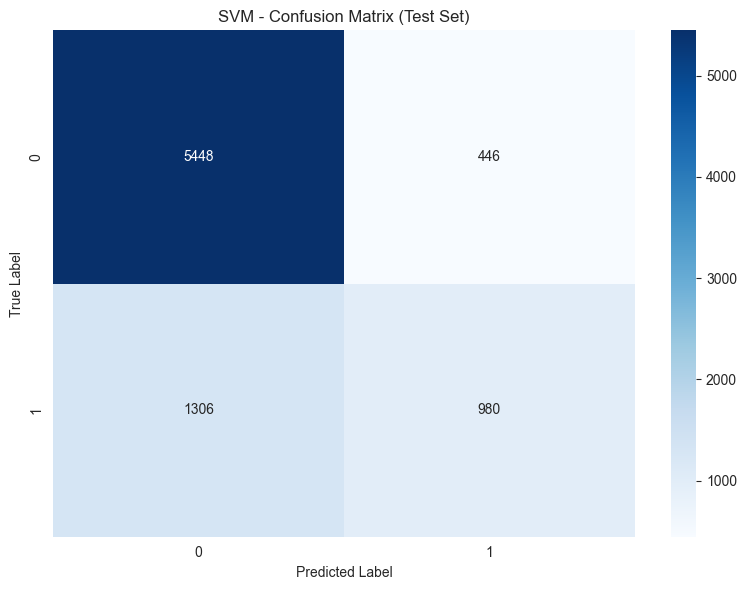

In [15]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'{MODEL_NAME} - Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 5.4 Save Final Results

In [16]:
# Salvar resultados finais usando função do módulo
model_final_results = save_final_results(
    model_name=MODEL_NAME,
    best_params=best_params,
    best_score=best_score,
    train_metrics=train_metrics,
    test_metrics=test_metrics,
    y_pred=y_test_pred,
    y_test=y_test_eval,
    X_train_scaled=X_train_eval,
    X_test_scaled=X_test_eval,
    results_folder=RESULTS_FOLDER
)

# Mostrar resumo final
print(f"\n--- RESUMO FINAL {MODEL_NAME} ---")
print(f"F1-Score CV: {model_final_results['best_cv_score']:.4f}")
print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
print(f"Acurácia Teste: {test_metrics['accuracy']:.4f}")
print(f"Precisão Teste: {test_metrics['precision']:.4f}")
print(f"Recall Teste: {test_metrics['recall']:.4f}")
print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
if test_metrics.get('auc_roc'):
    print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")

print(f"\nAvaliação do {MODEL_NAME} concluída com sucesso!")
print(f"Resultados salvos em: {RESULTS_FOLDER}/")
print(f"Modelo salvo em: {MODELS_FOLDER}/")
print(f"Histórico de busca salvo em: {SEARCHES_FOLDER}/")

✅ Resultados SVM salvos em: results\svm_results.json

--- RESUMO FINAL SVM ---
F1-Score CV: 0.5223
F1-Score Teste: 0.5280
Acurácia Teste: 0.7858
Precisão Teste: 0.6872
Recall Teste: 0.4287
G-Mean Teste: 0.6295
AUC-ROC Teste: 0.7828

Avaliação do SVM concluída com sucesso!
Resultados salvos em: results/
Modelo salvo em: models/
Histórico de busca salvo em: searches/
